In [1]:
# STEP 1: Load and Pre-Process Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import scipy.stats as st
from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
np.random.seed(100)
tf.random.set_seed(100)

In [3]:
# Load data
raw = pd.read_csv('Implied_Volatility_Data_vFinal.csv')
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(n=5)

Size of the dataset (row, col):  (125700, 5)


,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,20140630,0.006678,0.184,0.745927,0.008462
1,20140630,0.006678,2.252,0.286911,0.002024
2,20140630,0.006678,0.124,0.902941,0.019707
3,20140630,0.006678,2.144,0.910926,0.006424
4,20140630,0.006678,1.412,0.885760,0.005673


In [4]:
# Feature engineering
feature_names = ['x1', 'x2', 'x3']
X = raw[['SPX Return', 'Time to Maturity in Year', 'Delta']].copy()
X.columns = feature_names
y = raw['Implied Volatility Change']

# Train-test split & scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [5]:
# STEP 2: Create and Train the DNN
inputs = Input(shape=(X_scaled_train.shape[1],))
x = Dense(20, activation='relu')(inputs)
x = Dense(20, activation='relu')(x)
x = Dense(20, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-6)
]

history = model.fit(X_scaled_train, y_train, validation_split=0.2, epochs=100,
                    batch_size=32, callbacks=callbacks, verbose=1)

Epoch 1/100
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 6.9533e-04 - mse: 6.9533e-04 - val_loss: 8.2018e-05 - val_mse: 8.2018e-05 - learning_rate: 0.0010
Epoch 2/100
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.4825e-05 - mse: 8.4825e-05 - val_loss: 7.5927e-05 - val_mse: 7.5927e-05 - learning_rate: 0.0010
Epoch 3/100
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7.9303e-05 - mse: 7.9303e-05 - val_loss: 7.3964e-05 - val_mse: 7.3964e-05 - learning_rate: 0.0010
Epoch 4/100
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 7.6179e-05 - mse: 7.6179e-05 - val_loss: 7.1977e-05 - val_mse: 7.1977e-05 - learning_rate: 0.0010
Epoch 5/100
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.3985e-05 - mse: 7.3985e-05 - val_loss: 6.9948e-05 - val_mse: 6.9948e-05 - learning_rate: 0.0010
Epoch 6/100
2514/2514 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.2782e-05 - mse: 7.2782e-05 - val_loss: 6.9126e-05 - val_mse: 6.9126e-05 - learning_rate: 0.0010
Epoch 7/100
2514/2514 ━━━━━━

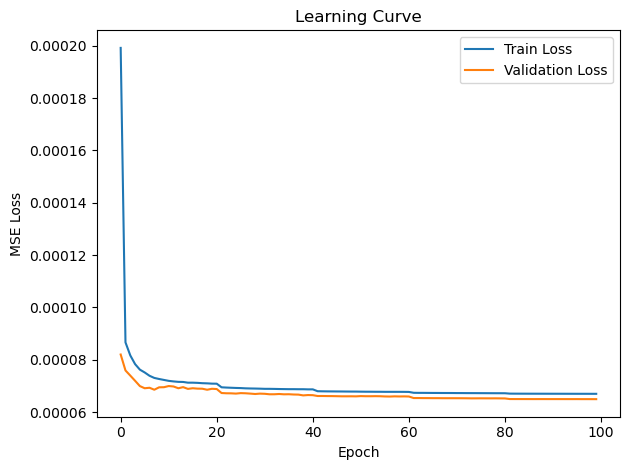

In [18]:
# STEP 3: Evaluate the Model
# Training history plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Test MSE
y_pred = model.predict(X_scaled_test).flatten()
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE = {test_mse:.6f}")

786/786 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test MSE = 0.000064


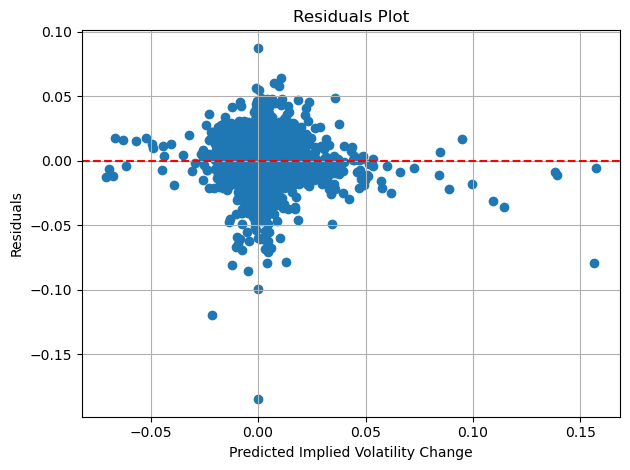

In [20]:
# Residuals plot
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Implied Volatility Change')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


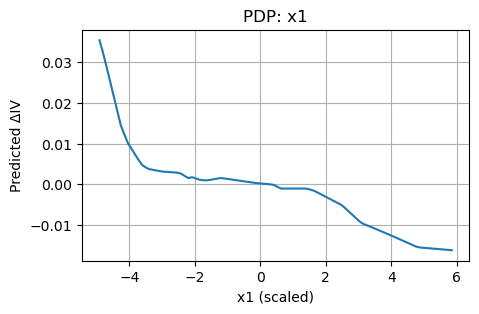

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


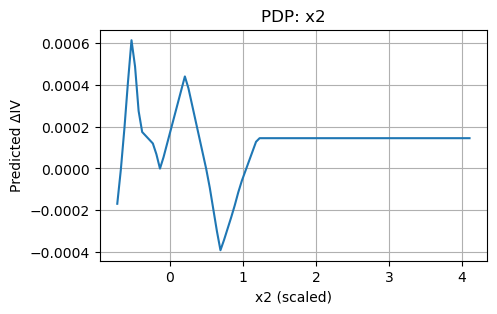

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


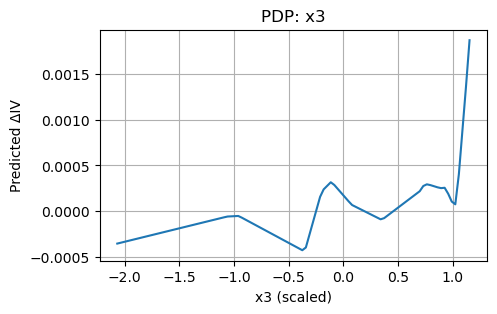

In [21]:
# === Partial Dependence Plots ===

for i, fname in enumerate(['x1','x2','x3']):
    grid = np.linspace(X_scaled_train[:,i].min(),
                       X_scaled_train[:,i].max(), 100)
    X_grid = np.tile(X_scaled_train.mean(axis=0), (100,1))
    X_grid[:,i] = grid
    preds = model.predict(X_grid).flatten()
    plt.figure(figsize=(5,3))
    plt.plot(grid, preds)
    plt.title(f'PDP: {fname}')
    plt.xlabel(f'{fname} (scaled)')
    plt.ylabel('Predicted ΔIV')
    plt.grid(True)
    plt.show()

ExactExplainer explainer: 25141it [10:24, 40.28it/s]                                                                   


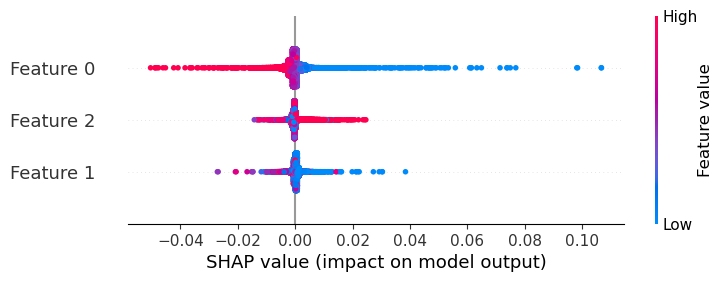

In [31]:
# STEP 4: SHAP Plot
#explainer = shap.KernelExplainer(model.predict, X_scaled_train[:500])
#shap_values = explainer.shap_values(X_scaled_test[:500])
#shap.summary_plot(shap_values, X_scaled_test[:500], feature_names=feature_names)
explainer = shap.Explainer(model, X_scaled_train)
shap_values = explainer(X_scaled_test)
shap.plots.beeswarm(shap_values)

In [32]:
# LIME Explanation for one test sample
lime_explainer = LimeTabularExplainer(
    training_data=X_scaled_train,
    feature_names=feature_names,
    class_names=['Implied Volatility Change'],
    mode='regression',
    discretize_continuous=True
)
lime_exp = lime_explainer.explain_instance(
    X_scaled_test[0], model.predict
)
lime_exp.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


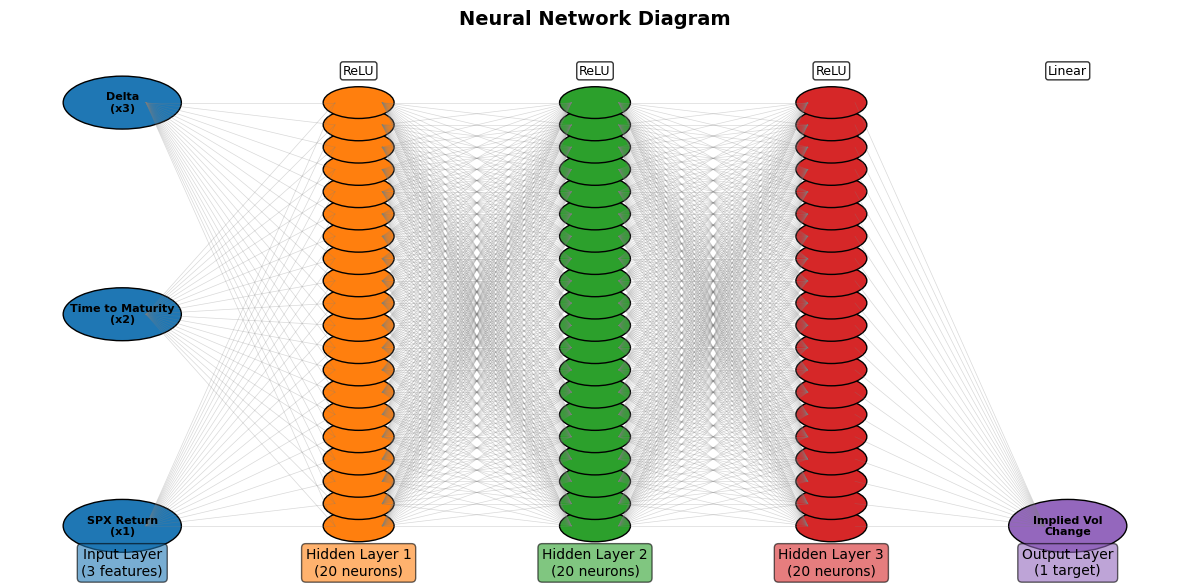

In [33]:
# STEP 5: Neural Network Visualization
layer_sizes = [3, 20, 20, 20, 1]
feature_labels = ['SPX Return\n(x1)', 'Time to Maturity\n(x2)', 'Delta\n(x3)']
output_label = 'Implied Vol\nChange'
activation_hidden = 'ReLU'
activation_output = 'Linear'

cmap = plt.get_cmap('tab10')
node_color_map = [cmap(i) for i in range(len(layer_sizes))]
x_positions = np.linspace(0.1, 0.9, len(layer_sizes))

layer_coords = []
for i, size in enumerate(layer_sizes):
    x = x_positions[i]
    y_positions = np.linspace(0.1, 0.9, size)
    coords = [(x, y) for y in y_positions]
    layer_coords.append(coords)

plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.axis('off')

for i, coords in enumerate(layer_coords):
    color = node_color_map[i]
    radius = 0.05 if i in (0, len(layer_sizes) - 1) else 0.03
    for j, (x, y) in enumerate(coords):
        circle = plt.Circle((x, y), radius=radius, color=color, ec='black', lw=1)
        ax.add_patch(circle)
        if i == 0 and j < len(feature_labels):
            ax.text(x, y, feature_labels[j], ha='center', va='center', fontsize=8, weight='bold')
        if i == len(layer_sizes) - 1:
            ax.text(x, y, output_label, ha='center', va='center', fontsize=8, weight='bold')

for i in range(len(layer_sizes) - 1):
    for (x1, y1) in layer_coords[i]:
        for (x2, y2) in layer_coords[i + 1]:
            ax.plot([x1 + 0.02, x2 - 0.02], [y1, y2], color='gray', alpha=0.3, lw=0.5)

for idx, size in enumerate(layer_sizes):
    label = (f"Input Layer\n({size} features)" if idx == 0 else
             f"Hidden Layer {idx}\n({size} neurons)" if idx < len(layer_sizes) - 1 else
             f"Output Layer\n({size} target)")
    ax.text(x_positions[idx], 0.03, label, ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor=node_color_map[idx], alpha=0.6))

for idx in range(1, len(layer_sizes) - 1):
    ax.text(x_positions[idx], 0.96, activation_hidden, ha='center', va='center',
            fontsize=9, bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
ax.text(x_positions[-1], 0.96, activation_output, ha='center', va='center',
        fontsize=9, bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

ax.set_title('Neural Network Diagram',
             fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()